In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# Enable inline plotting  
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-2-94f2cde48825>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [32]:
class Data(object):
    
    cores_per_node = {
                      '1': [1, 2, 4, 8, 16, 24, 28],
                      '2': [28, 42, 56],
                      '4': [56, 74, 102],
                      '6': [140, 154, 168],
                      '8': [196, 210, 224],
                      '12': [308, 322, 336],
                      '16': [420, 434, 448]
                     }
        
        
    columns = ['rank', 'init total', 'init topology', 'init trajectory', 
               'loop', 'loop/frame', 'io', 'io/frame', 'rmsd compute', 
               'rmsd compute/frame', 'comm init', 'comm gather',
               'comm total', 'total bench']
    
    
    def __init__(self, filepath, n_repeats):
        
        self.path = filepath
        self.n_repeats = n_repeats
    
    
    def plot_bars(self, N, trial):
        
        for cores in self.cores_per_node[str(N)]:
            
            n = cores
            
            a = np.load(f'{N}node_{trial}/{n}process_times.npy')
   
            dframe = pd.DataFrame(list(a), columns=self.columns).set_index('rank')
            
            #fig_name = 'bar plot'

            init_top = dframe.loc[:, 'init topology']
            init_traj = dframe.loc[:, 'init trajectory']
            io = dframe.loc[:, 'io']
            compute = dframe.loc[:, 'rmsd compute']
            comm = dframe.loc[:, 'comm total']

            ax = init_top.plot(kind='bar', figsize=(6,4) if N < 12 else (12,8), color='blue', label='Initialize Topology')
            ax = init_traj.plot(kind='bar', figsize=(6,4) if N < 12 else (12,8), color='red', label='Initialize Trajectory', bottom=init_top)
            #ax = io.plot(kind='bar', figsize=(8,6), color='green', label='io', bottom=init_traj)
            ax = compute.plot(kind='bar', figsize=(6,4) if N < 12 else (12,8), color='green', label='Compute RMSD', 
                              bottom=[init_top.iloc[j]+init_traj.iloc[j] for j in range(len(init_top))])
            ax = comm.plot(kind='bar', figsize=(6,4) if N < 12 else (12,8), color='black', label='Communication', 
                           bottom=[init_top.iloc[j] + init_traj.iloc[j] + compute[j] for j in range(len(init_top))])

            ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')

            plt.style.use('ggplot')
            sns.set_style('ticks')
            plt.rcParams['font.size'] = 12
            ax.set_xlabel('Processor Ranks')   
            ax.set_ylabel('Total Time (s)')
            ax.set_title(f'{N} Nodes, {n} Processes')
            sns.despine(offset=10, ax=ax)

            plt.xticks(range(0,n,20), range(0,n,20))
            plt.tight_layout()
            lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2), frameon=False, shadow=True, ncol=2, prop={'size':12})
            plt.show()
        
    def plot_scaling(self):
        
        times, stds = self.means_dataframe()
        
        n_proc = times.index.to_numpy()
        t_io = times.IO.to_numpy()
        t_rmsd = times.RMSD.to_numpy()
        t_total = times.Total_Benchmark_Time.to_numpy()
        
        
        speedup_rmsd = [t_rmsd[0]/t_rmsd[i] for i in range(len(t_rmsd))]
        efficiency_rmsd = [speedup_rmsd[i]/n_proc[i] for i in range(len(t_rmsd))]
        speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
        efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
        speedup_total = [t_total[0]/t_total[i] for i in range(len(t_total))]
        efficiency_total = [speedup_total[i]/n_proc[i] for i in range(len(t_total))]

        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
        plt.style.use('ggplot')
        sns.set_style('ticks')

        ax1.plot(times.index, times.index, 'k--')
        ax1.plot(times.index, speedup_rmsd, marker='.', color='orange', label='RMSD')
        ax1.plot(times.index, speedup_io, marker='.', color='blue', label='IO')
        ax1.set_title('Speedup')
        ax1.set(xlabel='$N_{Processes}$', ylabel='Speedup')
        ax1.legend()

        ax2.set_title('Efficiency')
        ax2.plot(times.index, efficiency_rmsd, marker='.', color='orange', label='RMSD')
        ax2.plot(times.index, efficiency_io, marker='.', color='blue', label='IO')
        ax2.set_ylim(0,1.2)
        ax2.set(xlabel='$N_{Processes}$', ylabel='Efficiency')
        ax2.legend()

        ax3.plot(times.index, times.index, 'k--')
        ax3.plot(times.index, speedup_total, marker='.')
        ax3.set_title('Total Speedup')
        ax3.set(xlabel='$N_{Processes}$', ylabel='Speedup')

        ax4.set_title('Total Efficiency')
        ax4.plot(times.index, efficiency_total, marker='.')
        ax4.set_ylim(0,1.2)
        ax4.set(xlabel='$N_{Processes}$', ylabel='Efficiency')
        
        
    def plot_total_time_line(self):
        
        times, stds = self.means_dataframe()
        
        n_proc = times.index.to_numpy()
        t_total = times.Total_Benchmark_Time.to_numpy()
        
        t_total_stds = stds.Total_Benchmark_Time.to_numpy()
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1)
        
        plt.style.use('ggplot')
        sns.set_style('ticks')

        #ax.plot(n_proc, n_proc, 'k--')
        #ax.errplot(n_proc, t_total, yerr=t_total_stds, marker='.')
        plt.errorbar(n_proc, t_total, yerr=t_total_stds, marker='.')
        plt.xscale('log')
        plt.yscale('log')
        ax.set_xlim(1,224)
        ax.set_ylim(0,5000)
        #ax.set_title('Total Time')
        ax.set_xlabel('$N_{Processes}$', fontsize=18)
        ax.set_ylabel('Total time (s)', fontsize=18)
        ax.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        ax.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        ax.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        ax.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

        
    def means_dataframe(self):
        
        n_proc = []
        t_init_total = []
        t_init_top = []
        t_init_traj = []
        t_loop = []
        t_loop_per_frame = []
        t_io = []
        t_io_per_frame = []
        t_rmsd = []
        t_rmsd_per_frame = []
        t_comm_init = []
        t_comm_gather = []
        t_comm_total =[]
        t_total = []

        n_proc_stds = []
        t_init_total_stds = []
        t_init_top_stds = []
        t_init_traj_stds = []
        t_loop_stds = []
        t_loop_per_frame_stds = []
        t_io_stds = []
        t_io_per_frame_stds = []
        t_rmsd_stds = []
        t_rmsd_per_frame_stds = []
        t_comm_init_stds = []
        t_comm_gather_stds = []
        t_comm_total_stds =[]
        t_total_stds = []
    
        for i in [1, 2, 4, 6, 8, 12]:

            for cores in self.cores_per_node[f'{i}']:

                means, stds = self.extract_data_means(N=i, n=cores)

                n_proc.append(means[0])
                t_init_total.append(means[1])
                t_init_top.append(means[2])
                t_init_traj.append(means[3])
                t_loop.append(means[4])
                t_loop_per_frame.append(means[5])
                t_io.append(means[6])
                t_io_per_frame.append(means[7])
                t_rmsd.append(means[8])
                t_rmsd_per_frame.append(means[9])
                t_comm_init.append(means[10])
                t_comm_gather.append(means[11])
                t_comm_total.append(means[12])
                t_total.append(means[13])

                n_proc_stds.append(stds[0])
                t_init_total_stds.append(stds[1])
                t_init_top_stds.append(stds[2])
                t_init_traj_stds.append(stds[3])
                t_loop_stds.append(stds[4])
                t_loop_per_frame_stds.append(stds[5])
                t_io_stds.append(stds[6])
                t_io_per_frame_stds.append(stds[7])
                t_rmsd_stds.append(stds[8])
                t_rmsd_per_frame_stds.append(stds[9])
                t_comm_init_stds.append(stds[10])
                t_comm_gather_stds.append(stds[11])
                t_comm_total_stds.append(stds[12])
                t_total_stds.append(stds[13])

        times = pd.DataFrame({'N_Processes': n_proc,
                              'Total_Initialize': t_init_total,
                              'Initialize_Topology': t_init_top, 
                              'Initialize_Trajectory': t_init_traj,
                              'Total Loop': t_loop,
                              'Loop/Frame': t_loop_per_frame, 
                              'IO': t_io,
                              'IO/Frame': t_io_per_frame, 
                              'RMSD': t_rmsd,
                              'RMSD/Frame': t_rmsd_per_frame,
                              'Comm_init': t_comm_init,
                              'Comm_Gather': t_comm_gather,
                              'Total_Communication': t_comm_total,
                              'Total_Benchmark_Time': t_total}).set_index('N_Processes')
        
        
        stds = pd.DataFrame({'N_Processes': n_proc_stds,
                              'Total_Initialize': t_init_total_stds,
                              'Initialize_Topology': t_init_top_stds, 
                              'Initialize_Trajectory': t_init_traj_stds,
                              'Total_Loop': t_loop_stds,
                              'Loop/Frame': t_loop_per_frame_stds, 
                              'IO': t_io_stds,
                              'IO/Frame': t_io_per_frame_stds, 
                              'RMSD': t_rmsd_stds,
                              'RMSD/Frame': t_rmsd_per_frame_stds,
                              'Comm_init': t_comm_init_stds,
                              'Comm_Gather': t_comm_gather_stds,
                              'Total_Communication': t_comm_total_stds,
                              'Total_Benchmark_Time': t_total_stds}).set_index('N_Processes')
        
        return times, stds
    
    def maxes_dataframe(self):
        
        n_proc = []
        t_init_total = []
        t_init_top = []
        t_init_traj = []
        t_loop = []
        t_loop_per_frame = []
        t_io = []
        t_io_per_frame = []
        t_rmsd = []
        t_rmsd_per_frame = []
        t_comm_init = []
        t_comm_gather = []
        t_comm_total =[]
        t_total = []

        n_proc_stds = []
        t_init_total_stds = []
        t_init_top_stds = []
        t_init_traj_stds = []
        t_loop_stds = []
        t_loop_per_frame_stds = []
        t_io_stds = []
        t_io_per_frame_stds = []
        t_rmsd_stds = []
        t_rmsd_per_frame_stds = []
        t_comm_init_stds = []
        t_comm_gather_stds = []
        t_comm_total_stds =[]
        t_total_stds = []
    
        for i in [1, 2, 4, 6, 8, 12]:

            for cores in self.cores_per_node[f'{i}']:

                means, stds = self.extract_data_maxes(N=i, n=cores)

                n_proc.append(means[0])
                t_init_total.append(means[1])
                t_init_top.append(means[2])
                t_init_traj.append(means[3])
                t_loop.append(means[4])
                t_loop_per_frame.append(means[5])
                t_io.append(means[6])
                t_io_per_frame.append(means[7])
                t_rmsd.append(means[8])
                t_rmsd_per_frame.append(means[9])
                t_comm_init.append(means[10])
                t_comm_gather.append(means[11])
                t_comm_total.append(means[12])
                t_total.append(means[13])

                n_proc_stds.append(stds[0])
                t_init_total_stds.append(stds[1])
                t_init_top_stds.append(stds[2])
                t_init_traj_stds.append(stds[3])
                t_loop_stds.append(stds[4])
                t_loop_per_frame_stds.append(stds[5])
                t_io_stds.append(stds[6])
                t_io_per_frame_stds.append(stds[7])
                t_rmsd_stds.append(stds[8])
                t_rmsd_per_frame_stds.append(stds[9])
                t_comm_init_stds.append(stds[10])
                t_comm_gather_stds.append(stds[11])
                t_comm_total_stds.append(stds[12])
                t_total_stds.append(stds[13])

        times = pd.DataFrame({'N_Processes': n_proc,
                              'Total_Initialize': t_init_total,
                              'Initialize_Topology': t_init_top, 
                              'Initialize_Trajectory': t_init_traj,
                              'Total Loop': t_loop,
                              'Loop/Frame': t_loop_per_frame, 
                              'IO': t_io,
                              'IO/Frame': t_io_per_frame, 
                              'RMSD': t_rmsd,
                              'RMSD/Frame': t_rmsd_per_frame,
                              'Comm_init': t_comm_init,
                              'Comm_Gather': t_comm_gather,
                              'Total_Communication': t_comm_total,
                              'Total_Benchmark_Time': t_total}).set_index('N_Processes')
        
        
        stds = pd.DataFrame({'N_Processes': n_proc_stds,
                              'Total_Initialize': t_init_total_stds,
                              'Initialize_Topology': t_init_top_stds, 
                              'Initialize_Trajectory': t_init_traj_stds,
                              'Total_Loop': t_loop_stds,
                              'Loop/Frame': t_loop_per_frame_stds, 
                              'IO': t_io_stds,
                              'IO/Frame': t_io_per_frame_stds, 
                              'RMSD': t_rmsd_stds,
                              'RMSD/Frame': t_rmsd_per_frame_stds,
                              'Comm_init': t_comm_init_stds,
                              'Comm_Gather': t_comm_gather_stds,
                              'Total_Communication': t_comm_total_stds,
                              'Total_Benchmark_Time': t_total_stds}).set_index('N_Processes')
        
        return times, stds
        
    def plot_line_means(self, init_total=False, maxes=False):
        
        if maxes:
            times, stds = self.maxes_dataframe()
        else:
            times, stds = self.means_dataframe()
        t_io_stds = stds.IO.to_numpy()
        t_rmsd_stds = stds.RMSD.to_numpy()
        t_init_total_stds = stds.Total_Initialize.to_numpy()
        t_init_top_stds = stds.Initialize_Topology.to_numpy()
        t_init_traj_stds = stds.Initialize_Trajectory.to_numpy()
        t_comm_total_stds = stds.Total_Communication.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        if init_total:
            yerrs = [t_io_stds, t_rmsd_stds, t_init_total_stds, t_comm_total_stds]
            times.loc[:, ['IO', 'RMSD', 'Total_Initialize', 'Total_Communication']].plot(color=['blue',
                                                                                      'orange', 
                                                                                      'purple',
                                                                                      'red'], yerr=yerrs, ax=axes)
            lgd = plt.legend(['IO', 'RMSD','Initialize', 'Communication'],
                             loc='upper center', bbox_to_anchor=(0.43, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        else:
            yerrs = [t_io_stds, t_rmsd_stds, t_init_top_stds, t_init_traj_stds, t_comm_total_stds]
            times.loc[:, ['IO','RMSD','Initialize_Topology',
                          'Initialize_Trajectory','Total_Communication']].plot(color=['blue',
                                                                                      'orange', 
                                                                                      'black',
                                                                                      'green',
                                                                                      'red'], yerr=yerrs, ax=axes)
            lgd = plt.legend(['IO', 'RMSD','Initialize Topology', 
                              'Initialize Trajectory', 'Communication'],
                             loc='upper center', bbox_to_anchor=(0.43, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$')
        axes.set_ylabel('Time (s)')
        axes.set_title('90K Frames')
        plt.xscale('log')
        plt.yscale('log')
        axes.set_ylim(0,10000)
        axes.set_xlim(1, 500)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)
    
    def dataframe(self, N, n):
            
        _dict = {f'a{i}': np.load(self.path + f'{N}node_{i}/{n}process_times.npy') for i in range(1, self.n_repeats+1)}
        arrays = tuple(_dict.values())
        a = np.hstack(arrays)
            
        dframe = pd.DataFrame(list(a), columns=3*self.columns)
        
        return dframe
    
    
    def dataframe_avgs(self, N, n):
        
        _dict = {f'a{i}': np.load(self.path + f'{N}node_{i}/{n}process_times.npy') for i in range(1, self.n_repeats+1)}

        i = 1
        a = _dict['a1']
        while i < self.n_repeats:
            a += _dict[f'a{i+1}']
            i += 1
        
        a = a/self.n_repeats
            
        dframe = pd.DataFrame(list(a), columns=self.columns).set_index('rank')
        
        return dframe
    
    
    def extract_data_means(self, N, n):

        init_total = np.empty(self.n_repeats)
        init_top = np.empty_like(init_total)
        init_traj = np.empty_like(init_total)
        loop = np.empty_like(init_total)
        loop_per_frame = np.empty_like(init_total)
        io = np.empty_like(init_total)
        io_per_frame = np.empty_like(init_total)
        rmsd = np.empty_like(init_total)
        rmsd_per_frame = np.empty_like(init_total)
        comm_init = np.empty_like(init_total)
        comm_gather = np.empty_like(init_total)
        comm_total = np.empty_like(init_total)
        total = np.empty_like(init_total)

        _dict = {f'a{i}': np.load(self.path + f'{N}node_{i}/{n}process_times.npy') for i in range(1, self.n_repeats+1)}


        if n == 1:
            for i, array in enumerate(_dict.values()):
                init_total[i] = array[:, 1]
                init_top[i] = array[:, 2]
                init_traj[i] = array[:, 3]
                loop[i] = array[:, 4]
                loop_per_frame[i] = array[:, 5]
                io[i] = array[:, 6]
                io_per_frame[i] = array[:, 7]
                rmsd[i] = array[:, 8]
                rmsd_per_frame[i] = array[:, 9]
                comm_init[i] = array[:, 10]
                comm_gather[i] = array[:, 11]
                comm_total[i] = array[:, 12]
                total[i] = array[:, 13]
        else:
            for i, array in enumerate(_dict.values()):
                init_total[i] = np.mean(array[:, 1])
                init_top[i] = np.mean(array[:, 2])
                init_traj[i] = np.mean(array[:, 3])
                loop[i] = np.mean(array[:, 4])
                loop_per_frame[i] = np.mean(array[:, 5])
                io[i] = np.mean(array[:, 6])
                io_per_frame[i] = np.mean(array[:, 7])
                rmsd[i] = np.mean(array[:, 8])
                rmsd_per_frame[i] = np.mean(array[:, 9])
                comm_init[i] = np.mean(array[:, 10])
                comm_gather[i] = np.mean(array[:, 11])
                comm_total[i] = np.mean(array[:, 12])
                total[i] = np.mean(array[:, 13])


        means = [n, np.mean(init_total), np.mean(init_top), np.mean(init_traj), np.mean(loop), 
                 np.mean(loop_per_frame), np.mean(io), np.mean(io_per_frame), np.mean(rmsd), 
                 np.mean(rmsd_per_frame), np.mean(comm_init), np.mean(comm_gather),
                 np.mean(comm_total), np.mean(total)]
        stds = [n, np.std(init_total),  np.std(init_top), np.std(init_traj), np.std(loop), 
                np.std(loop_per_frame), np.std(io), np.std(io_per_frame), np.std(rmsd), 
                np.std(rmsd_per_frame), np.std(comm_init), np.std(comm_gather), 
                np.std(comm_total), np.std(total)]

        return means, stds
    
    def extract_data_maxes(self, N, n):
        
        init_total = np.empty(self.n_repeats)
        init_top = np.empty_like(init_total)
        init_traj = np.empty_like(init_total)
        loop = np.empty_like(init_total)
        loop_per_frame = np.empty_like(init_total)
        io = np.empty_like(init_total)
        io_per_frame = np.empty_like(init_total)
        rmsd = np.empty_like(init_total)
        rmsd_per_frame = np.empty_like(init_total)
        comm_init = np.empty_like(init_total)
        comm_gather = np.empty_like(init_total)
        comm_total = np.empty_like(init_total)
        total = np.empty_like(init_total)

        _dict = {f'a{i}': np.load(self.path + f'{N}node_{i}/{n}process_times.npy') for i in range(1, self.n_repeats+1)}

        if n == 1:
            for i, array in enumerate(_dict.values()):
                init_total[i] = array[:, 1]
                init_top[i] = array[:, 2]
                init_traj[i] = array[:, 3]
                loop[i] = array[:, 4]
                loop_per_frame[i] = array[:, 5]
                io[i] = array[:, 6]
                io_per_frame[i] = array[:, 7]
                rmsd[i] = array[:, 8]
                rmsd_per_frame[i] = array[:, 9]
                comm_init[i] = array[:, 10]
                comm_gather[i] = array[:, 11]
                comm_total[i] = array[:, 12]
                total[i] = array[:, 13]
        else:
            for i, array in enumerate(_dict.values()):
                init_total[i] = np.max(array[:, 1])
                init_top[i] = np.max(array[:, 2])
                init_traj[i] = np.max(array[:, 3])
                loop[i] = np.max(array[:, 4])
                loop_per_frame[i] = np.max(array[:, 5])
                io[i] = np.max(array[:, 6])
                io_per_frame[i] = np.max(array[:, 7])
                rmsd[i] = np.max(array[:, 8])
                rmsd_per_frame[i] = np.max(array[:, 9])
                comm_init[i] = np.max(array[:, 10])
                comm_gather[i] = np.max(array[:, 11])
                comm_total[i] = np.max(array[:, 12])
                total[i] = np.max(array[:, 13])


        means = [n, np.mean(init_total), np.mean(init_top), np.mean(init_traj), np.mean(loop), 
                 np.mean(loop_per_frame), np.mean(io), np.mean(io_per_frame), np.mean(rmsd), 
                 np.mean(rmsd_per_frame), np.mean(comm_init), np.mean(comm_gather),
                 np.mean(comm_total), np.mean(total)]
        stds = [n, np.std(init_total),  np.std(init_top), np.std(init_traj), np.std(loop), 
                np.std(loop_per_frame), np.std(io), np.std(io_per_frame), np.std(rmsd), 
                np.std(rmsd_per_frame), np.std(comm_init), np.std(comm_gather), 
                np.std(comm_total), np.std(total)]

        return means, stds

In [33]:
data = Data('10-14/', n_repeats=3)

<ipython-input-32-d80fafba48b4>:134: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,5000)


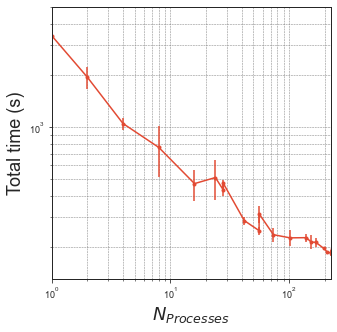

In [34]:
data.plot_total_time_line()

<ipython-input-32-d80fafba48b4>:389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(0,10000)


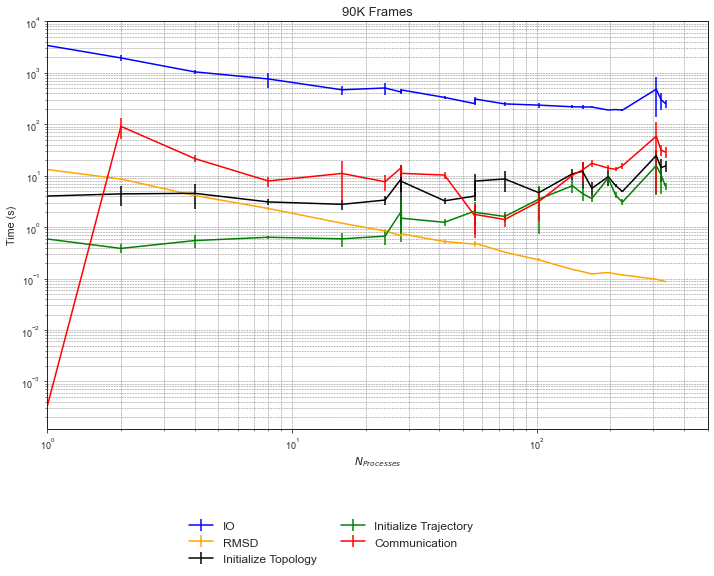

In [36]:
data.plot_line_means(maxes=True)

In [ ]:
data.plot_total_time_line()

In [6]:
times, stds = data.means_dataframe()
times.describe()

IndexError: index 13 is out of bounds for axis 1 with size 13

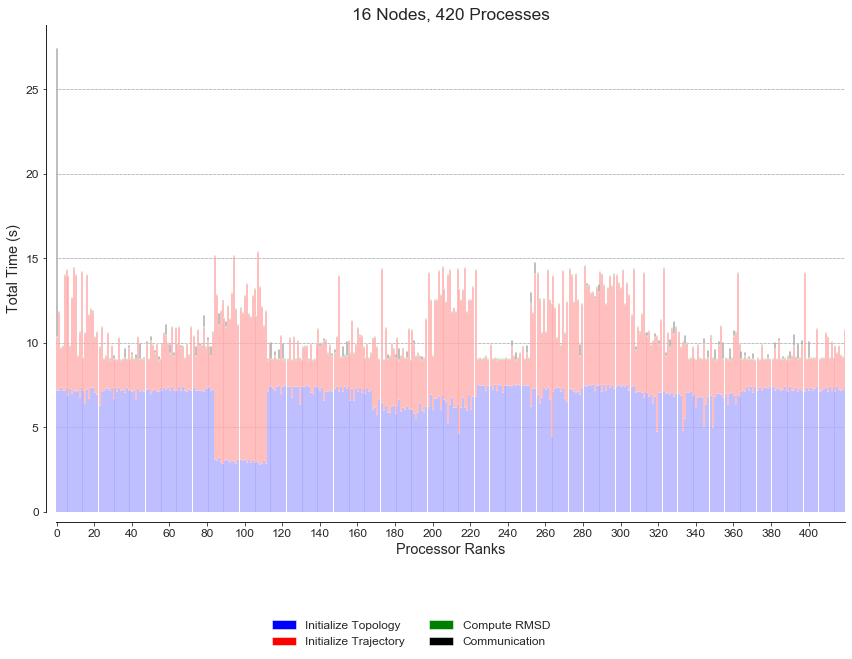

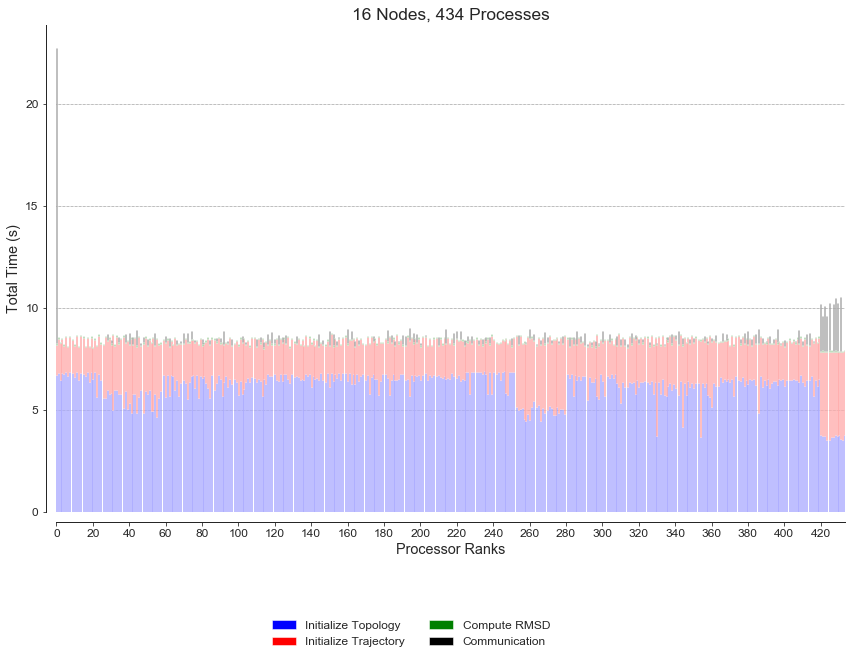

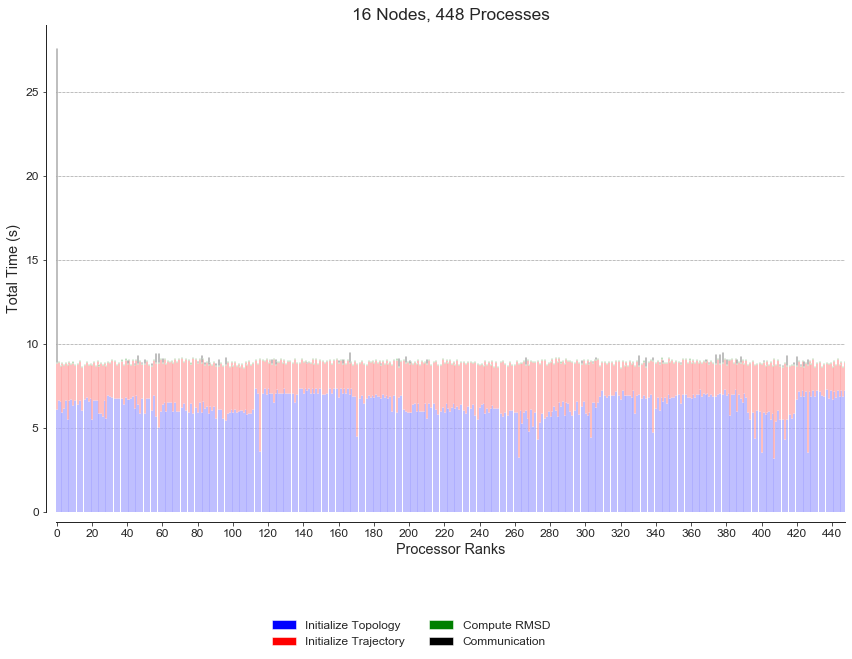

In [81]:
data.plot_bars(16, 1)